# STAYSL Walk-through NIF
This example walks through the 
Passive 18x snout on TANDM 90-348 NIF Foil Activation Experiment performed by
Energetic Neutron Platform Working Group and NIF Radiochemistry Group

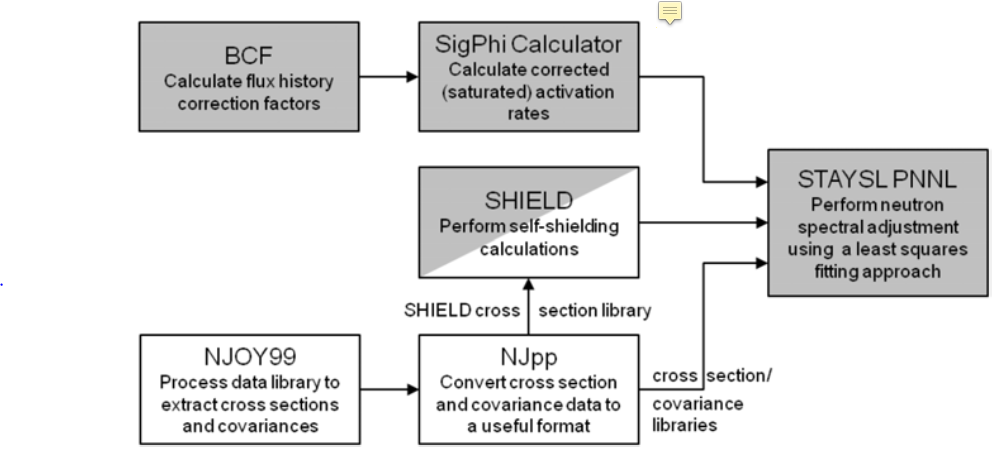
- This is from EPJWeb of Conferences 106, 07001 (2016) Least-Squares Neutron Spectral Adjustment with STAYSL PNNL L.R. Greenwooda and C.D. Johnson

# BCF - Beam Correction Factor
BCF corrects for irradiation history. The calculations performed correct for production and decay during the irradiation. At constant power or flux, this is a simple process 

$A_{0}=A_{\infty}*(1-exp(-\lambda*t))$

BCF normalizes the irradiation history to the time-weighted average reactor power or beam current. A correction factor is produced based on the irradiation hisotry for each isotope of interest. 

For the NIF, this module is not needed, BCF is not needef for a short irradiation time

## SHIELD
The SHIELD code calculates energy-dependent neutron self-shielding cross section correction factors that are used, prior to neutron spectral adjustment, to shield the neutron activation cross sections used by the STAYSL PNNL code. 

SHIELD was performed on ["shldinputNIF.dat"](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SHIELD/shldinputNIF.dat). 

After a painstaking process of trial and error. It was determined that my executable of the SHIELD.exe can only be ran if: 
- Run command prompt as an administrator
- Use runExample batch file with filename replaced with desired input

I am unsure of why it requires this, I am guessing it is a permissions issue that I cannot work out. 

SHIELD is only necessary/valid on non-threshold reactions (n,gamma). SHIELD is dependent on the thickness of the material, so it must be re-ran if different foils/wires are used. 

An output file is created in the same directory shldinput.out

All foils are 1 mm (39.3701 mils) except for the Au foils, which are 0.1 mm

The output is renamed sshldlib.dat


## SigPhi Calculator

The [SigPhi Calculator](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SIGPHI/SigPhi_Calculator_NIF.xlsm) was filled in with data from the [foil and activity information] (https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/ActivationData.xlsx)


The purpose of the SigPhi Calculator software is to calculate corrected saturated neutron activation rates from measured activities. These reaction rates, the so-called sig-phi values, represent the product of the spectral-averaged neutron activation cross section and the total neutron flux

The NIF is a very prompt output (~200 ps). There will be some downscatter which may slow a portion down. However, for the purposes of the irradiation, the irradiation time is taken as 1 second, and the reaction rates are taken as per second. This will not impact the results because the half-lives of the measured products are orders of magnitude different from this result. 

The export to excel did not work. Instead, the input was built-up using the calculated gamma shielding and At/At-s from the foil and activity information sheet

I couldn't get the SigPhi Calculator to work for me. I redownloaded everything and it gives me: 
￿￿￿￿￿￿￿￿￿￿ when I try to export to a STAYSL script. After this is completed. I plan on sending in the bugs to PNNL

The sig-phi is calculated by dividing the number of nuclei created at t0 by the total number of atoms present in the foil. This is the relative production. 

The self-shielding factor for gammas is divided by this to correct for gamma self-shielding


# STAYSL

The STAYSL input deck was made with the SIG_PHI calculator and foil/activation data. 

The default values (From examples distributed with STAYSL) for Gaussian formalism were used. 

An iterative solution was performed on the input data and sets the uncertainty below 13 MeV to 100%. This was chosen because the model did not predict the down-scattering well. The baseline guess spectrum was initially developed using an Appelbe source split with a 14.03 MeV neutron peak at 10.75 keV temperature (See foil/activation Excel doc). 

After the initial results from the Appelbe source, it was clear that there was a large downscattering term. 

An estimation of the foil (13-14 MeV and 14-15 MeV) flux was done in the activation spreadsheet. The (n,2n) reactions were almost exactly what the guess predicted; however, the (n,g) and (n,n') reactions were underpredicting by over an order of magnitude. 

The guess spectrum was changed to a previous NIF shot. 

In [17]:
import sys
import os
sys.path.insert(0,os.path.abspath('C:/Users/nickq/Documents/AFIT_Masters/PyScripts/src'))
import pandas as pd
from DataAnalysis.DataManipulation import bin_integration, bin_differentiation
from DataAnalysis.Histograms import Histogram
import matplotlib
from Unfolding.STAYSLmodified import IterativeSTAYSL

%matplotlib inline
import scipy.stats as stats
#http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html

STAYSL is ran by executing the executable from the command line. The first iteration of STAYSL is performed manually. The output from that is placed into folder Iteration1. 

# Pinhole Results

In [18]:


path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

Plot first result

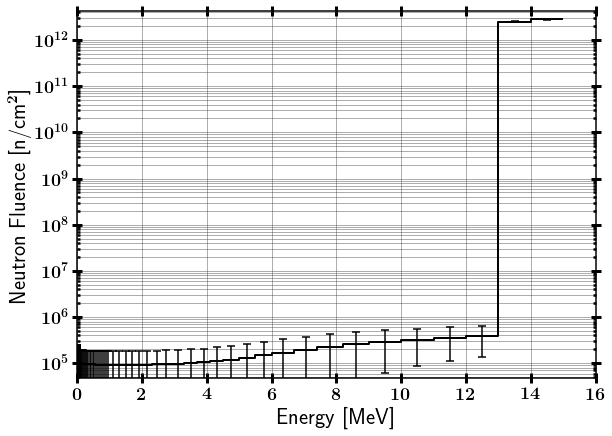

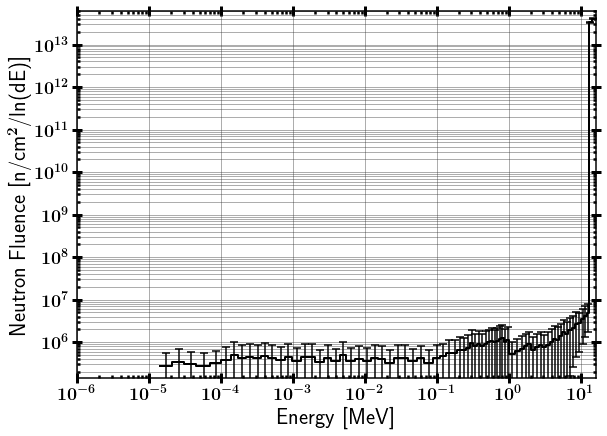

In [19]:


outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Pin Iterative Solution:
  - The iterative solution sets the uncertainty below 13 MeV to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.

In [21]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.1
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/stayslin.out
Chi^2 = 425.82122, Std Norm = 8.72242005122
Chi^2 = 425.09643
Chi^2 = 424.35495
Chi^2 = 423.58329
Chi^2 = 422.76782
Chi^2 = 421.86096
Chi^2 = 420.6634
Chi^2 = 417.58012
Chi^2 = 389.22381
Chi^2 = 258.29472
Chi^2 = 170.9789
Chi^2 = -110.44474
Chi^2 = -188.87621
Chi^2 = -207.06384
Chi^2 = -199.77938
Chi^2 = -219.31345
Chi^2 = -209.81921
Chi^2 = -206.0858
Chi^2 = -226.36649
Chi^2 = -216.34175
Chi^2 = -212.21857
Chi^2 = -233.89281
Chi^2 = -223.43442
Chi^2 = -218.49259
Chi^2 = -241.60149
Chi^2 = -230.7407
Chi^2 = -224.9024


KeyboardInterrupt: 

In [ ]:
print len(iterAdjHisto)
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{NIF Guess $\chi^{2}$/v = 4.4}')

iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, yMin=1, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                        savePath=outpath+'PIN-Unfold_Itr{:1d}'.format(iter),legendLoc=4)
iterAdjHisto[iter].plot(xMin=1E-6, xMax=20, yMin=1000, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                        savePath=outpath+'PINlog-Unfold_Itr{:1d}'.format(iter),legendLoc=2)



Find the p value 
Reject that the distributions are similar if p-value below threshold. 

In [47]:

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value= stats.chi2.sf(4.38*4.0, 4) 
print("P value")
print(p_value)

p_value= stats.chi2.sf(1,1) 
print("P value")
print(p_value)


Critical value
9.48772903678
P value
0.0015311937798
P value
0.317310507863


# Pinhole Results
- Starting from Flat Spectrum 

In [13]:
import pandas as pd
from DataAnalysis.DataManipulation import bin_integration, bin_differentiation

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_flat/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

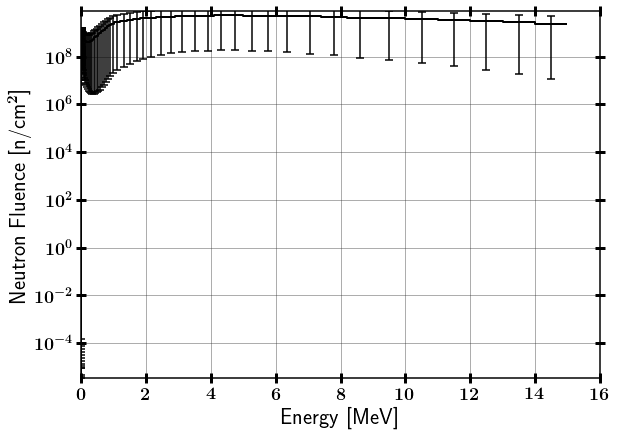

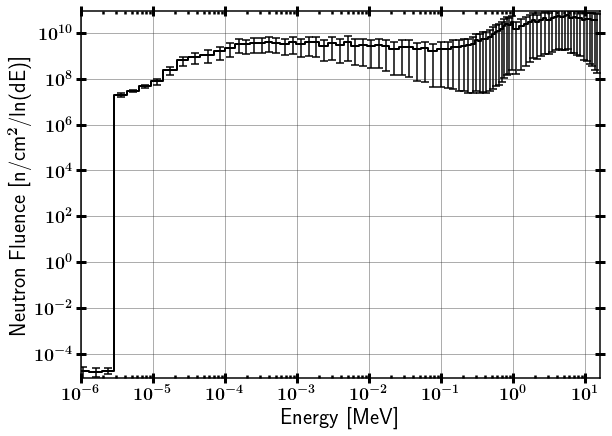

In [14]:
from DataAnalysis.Histograms import Histogram
import matplotlib
%matplotlib inline

outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_flat/'
fadjHisto = Histogram()
fadjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

fadjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
fadjLethargyHisto = Histogram()
fadjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

fadjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Flat Spectrum Pin Iterative Solution:
  - Start from Flat spectrum
  - The iterative solution sets all uncertainties to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.

In [15]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/PIN_N120405_flat/Iteration1/'

# Build Data Structure Lists
fiterSoln = []
fiterAdjHisto = []
fiterRatioHisto = []

fiterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.01))
print fiterSoln[-1]

fiterSoln[-1].run()

# Convert to lethargy
fiterSoln[-1]._df['adjLethargy'] =  bin_differentiation(fiterSoln[-1]._df['lowE'].tolist(),
                                                     fiterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
fiterAdjHisto.append(Histogram())
fiterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/PIN_N120405_flat/Iteration1/
$\chi^2$ Convergence: 0.01
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/PIN_N120405_flat/Iteration1/stayslin.out
Chi^2 = 5830.36413, Std Norm = 8.48611110286
Chi^2 = 91.56448
Chi^2 = -864.4982
Chi^2 = 8743.21746
Chi^2 = 3483.78515
Chi^2 = 3345.36312
Chi^2 = 3338.87968
Chi^2 = 3336.33811
Chi^2 = 3334.19788
Chi^2 = 3331.57229
Chi^2 = 3328.16426
Chi^2 = 3323.5946
Chi^2 = 3317.20893
Chi^2 = 3307.81195
Chi^2 = 3293.01943
Chi^2 = 3267.24995
Chi^2 = 3215.16235
Chi^2 = 3083.49641
Chi^2 = 2644.79882
Chi^2 = 1428.704
Chi^2 = 600.01171
Chi^2 = -228.51149
Chi^2 = -542.28219
Chi^2 = -552.24104
Chi^2 = -562.56664
Chi^2 = -572.37185
Chi^2 = -580.29323
Chi^2 = -585.91119
Chi^2 = -589.49048
Chi^2 = -591.33048
Chi^2 = -592.31613
Chi^2 = -

KeyboardInterrupt: 

In [ ]:
print len(fiterAdjHisto)
iter = 0
fiterAdjHisto[iter].build_histo(fiterSoln[iter]._df['lowE'].tolist(),fiterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(fiterSoln[iter]._df['adjStd']*fiterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{Flat Guess $\chi^{2}$/v = 6.6}')
#'Flat Guess-$\chi^{2}$ $\nu$ = 6.6')

fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-8, xMax=16, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=4,
                        savePath=outpath+'PinBoth',)
fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-7, xMax=20, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=2,
                        savePath=outpath+'PinBothLog')

# Basket
All values except for STAYSL are the same. Foil thicknesses are the same
Uncertainty in 13-14 MeV bins is set to 50%. Lower is set to 100%

In [ ]:
from Unfolding.STAYSL import IterativeSTAYSL

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

In [ ]:
outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Bask',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6,xMax=20.0,logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Bask_Lethargic',includeMarkers=False,
                  legend=False)

# Bask Iterative Solution:
  - The iterative solution sets the uncertainty to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.
  - Less is known about this flux. 
  - The starting guess spectrum is still the source term for the pin; however, it is scaled by the divergence (7^2/41^2)

In [ ]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

In [ ]:
print len(iterAdjHisto)
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name= '\\textbf{NIF Guess $\chi^{2}$/v = 18.7}')

iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'Bask-Unfold_Itr{:1d}'.format(iter))
iterAdjHisto[iter].plot(xMin=1E-7, xMax=20, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'Basklog-Unfold_Itr{:1d}'.format(iter))



Find the p-value

In [ ]:
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 5)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value= stats.chi2.sf(18.7*5, 5) 
print("P value")
print(p_value)

# Basket Results
- Starting from Flat Spectrum 

In [ ]:


path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/BASK_N120405_flat/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

In [ ]:
from DataAnalysis.Histograms import Histogram
import matplotlib
%matplotlib inline

outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/BASK_N120405_flat/'
fadjHisto = Histogram()
fadjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

fadjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'Pin1',includeMarkers=False,
                  legend=False)
fadjLethargyHisto = Histogram()
fadjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

fadjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'Pin1d_Lethargic',includeMarkers=False,
                  legend=False)

# Flat Spectrum Basket Iterative Solution:
  - Start from Flat spectrum
  - The iterative solution sets all uncertainties to 100%
  - It does not update the uncertainty until $\chi^2$ converged.

In [ ]:

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/BASK_N120405_flat/Iteration1/'

# Build Data Structure Lists
fiterSoln = []
fiterAdjHisto = []
fiterRatioHisto = []

fiterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

fiterSoln[-1].run()

# Convert to lethargy
fiterSoln[-1]._df['adjLethargy'] =  bin_differentiation(fiterSoln[-1]._df['lowE'].tolist(),
                                                     fiterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
fiterAdjHisto.append(Histogram())
fiterRatioHisto.append(Histogram())

In [ ]:
print len(fiterAdjHisto)
iter = 0
fiterAdjHisto[iter].build_histo(fiterSoln[iter]._df['lowE'].tolist(),fiterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(fiterSoln[iter]._df['adjStd']*fiterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{Flat Guess $\chi^{2}$/v =17.7}')

fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-8, xMax=16,yMin=1, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=2,
                        savePath=outpath+'BaskBoth',)
fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-6, xMax=20, yMin=1,logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=2,
                        savePath=outpath+'BaskBothLog')

In [ ]:
p_value= stats.chi2.sf(17.7*5, 5) 
print("P value")
print(p_value)

# Kinematic Base
All values except for STAYSL are the same. Foil thicknesses are the same

In [ ]:
from Unfolding.STAYSL import IterativeSTAYSL

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

In [ ]:
outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/'
adjHisto = Histogram()
adjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

adjHisto.plot(xMin=1E-6, yMin=1E5,logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'KBAS_init',includeMarkers=False,
                  legend=False)
adjLethargyHisto = Histogram()
adjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

adjLethargyHisto.plot( xMin=1E-6,xMax=20.0,logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'KBAS_Lethargic_init',includeMarkers=False,
                  legend=False)

# KBAS Iterative Solution:
  - The iterative solution sets the uncertainty to 100%.
  - It does not update the uncertainty until $\chi^2$ converged.
  - Less is known about this flux. 
  - The starting guess spectrum is still the source term for the pin; however, it is scaled by the divergence (7^2/41^2

In [ ]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

In [ ]:
print len(iterAdjHisto)
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{NIF Guess $\chi^{2}$/v = 0.4}')

iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, yMin=1e6, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'KBAS-Unfold_Itr{:1d}'.format(iter))
iterAdjHisto[iter].plot(xMin=1E-8, xMax=20, yMin=1000, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'KBASlog-Unfold_Itr{:1d}'.format(iter))

find the p-value

In [ ]:
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 5)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value= stats.chi2.sf(0.35*5., 5) 
print("P value")
print(p_value)

# Kinematic Base Results
- Starting from Flat Spectrum 

In [ ]:
path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_flat/stayslin.out'
df = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df.apply(pd.to_numeric)

df['adjFlux'] = bin_integration(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low')
df['adjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['adjFlux'].tolist(), 'low', True)
df['unadjFlux'] = bin_integration(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low')
df['unadjLethargy'] =  bin_differentiation(df['lowE'].tolist(), df['unadjFlux'].tolist(), 'low', True)

df['adjLethargyStd'] = df['adjStd'] * df['adjLethargy'] / 100
df['unadjLethargyStd'] = df['unadjStd'] * df['adjLethargy'] / 100
df['adjStd'] = df['adjStd'] * df['adjFlux'] / 100
df['unadjStd'] = df['unadjStd'] * df['unadjFlux'] / 100

#df['adjStd']

In [ ]:
outpath ='C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_flat/'
fadjHisto = Histogram()
fadjHisto.build_histo(df['lowE'].tolist(), df['adjFlux'].tolist(), uncert=df['adjStd'].tolist(),
                     edgeLoc='low')

fadjHisto.plot(xMin=1E-6, logX=False, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',
                  savePath=outpath+'FLATKBAS',includeMarkers=False,
                  legend=False)
fadjLethargyHisto = Histogram()
fadjLethargyHisto.build_histo(df['lowE'].tolist(), df['adjLethargy'].tolist(), uncert=df['adjLethargyStd'].tolist(),
                     edgeLoc='low')

fadjLethargyHisto.plot( xMin=1E-6, logX=True, logY=True,
                  xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$/ln(dE)]',
                  savePath=outpath+'flatKBASd_Lethargic',includeMarkers=False,
                  legend=False)

# Flat Spectrum KBAS Iterative Solution:
  - Start from Flat spectrum
  - The iterative solution sets all uncertainties to 100%
  - It does not update the uncertainty until $\chi^2$ converged.

In [ ]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_flat/Iteration1/'

# Build Data Structure Lists
fiterSoln = []
fiterAdjHisto = []
fiterRatioHisto = []

fiterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.1))
print iterSoln[-1]

fiterSoln[-1].run()

# Convert to lethargy
fiterSoln[-1]._df['adjLethargy'] =  bin_differentiation(fiterSoln[-1]._df['lowE'].tolist(),
                                                     fiterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
fiterAdjHisto.append(Histogram())
fiterRatioHisto.append(Histogram())

In [ ]:
print len(fiterAdjHisto)
iter = 0
fiterAdjHisto[iter].build_histo(fiterSoln[iter]._df['lowE'].tolist(),fiterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(fiterSoln[iter]._df['adjStd']*fiterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{Flat Guess $\chi^{2}$/v =0.5}')

fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-8, xMax=16, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=4,
                        savePath=outpath+'KBASBoth',)
fiterAdjHisto[iter].plot(iterAdjHisto[iter],xMin=1E-7, xMax=20, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legendLoc=2,
                        savePath=outpath+'KBASBothLog')


In [ ]:
crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 4)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value= stats.chi2.sf(5.*0.5, 5) 
print("P value")
print(p_value)